In [109]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# 3. Data Scaling

* Due to the different types of information that Categorical features and Numerical features provide, each requires unique data scaling methods. Therefore, before normalizing features, we must split them into numeric and categorical sets.
* Regarding the numerical variables, the objective is to place them into the same scale, from 0 to 1, where 1 refers to the maximum value of the feature while 0 refers to the minimum value of the feature. One reason for normalizing / scaling the data is to prevent the model from giving more importance to variables with larger absolute numbers, since we do not want to make any assumptions on the level of importance of each feature. It is relevant to mention that while scaling we only consider information obtained from the training data. Only after we can use the minimum and maximum values of the training dataset for each variable to scale the validation dataset.
* Concerning categorical features, these are encoded to be readable by the models, as these do not typically process non-numeric data directly. To do so, we used the Ordinal Encoder method to transform the categorical variables by assigning each category an unique integer based on its order or occurrence


## NEED THE X VAL AND X TRAIN Y VAL Y TRAIN PREPROCESSED

In [110]:
# load the data (train and test)
X_train_DS = pd.read_csv('datasets/feature_engineering_train_delivery1.csv', index_col=0)
X_val_DS = pd.read_csv('datasets/feature_engineering_val_delivery1.csv', index_col=0)
y_train_DS = pd.read_csv('datasets/feature_engineering_y_train_delivery1.csv', index_col=0)
y_val_DS = pd.read_csv('datasets/feature_engineering_y_val_delivery1.csv', index_col=0)

X_test_DS = pd.read_csv('datasets/feature_engineering_test_delivery1.csv', index_col=0)

In [111]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year', 'Assembly Year']
                    
categorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'Age Group',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Broad Body Part']
                        
binary_features = ['Alternative Dispute Resolution', 'Attorney/Representative','C-2 Date', 'C-3 Date', 'COVID-19 Indicator','Gender', 'Accident on Weekday','Frequent Injury Cause']
cyclic_features = ['Accident Month', 'Assembly Month']

In [112]:
# Split datasets into feature categories
X_train_numeric = X_train_DS[numeric_features]
X_train_categorical = X_train_DS[categorical_features]
X_train_binary = X_train_DS[binary_features]
X_train_cyclic = X_train_DS[cyclic_features]

X_val_numeric = X_val_DS[numeric_features]
X_val_categorical = X_val_DS[categorical_features]
X_val_binary = X_val_DS[binary_features]
X_val_cyclic = X_val_DS[cyclic_features]

X_test_numeric = X_test_DS[numeric_features]
X_test_categorical = X_test_DS[categorical_features]
X_test_binary = X_test_DS[binary_features]
X_test_cyclic = X_test_DS[cyclic_features]

## 3.1 Data Scaling for Numerical

In [113]:
# Initialize scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply RobustScaler
X_train_numeric_robust_scaled = pd.DataFrame(robust_scaler.fit_transform(X_train_DS[numeric_features]),
                              columns=numeric_features, 
                              index=X_train_DS.index)

X_val_numeric_robust_scaled = pd.DataFrame(robust_scaler.transform(X_val_DS[numeric_features]),
                                columns=numeric_features,
                                index=X_val_DS.index)

X_test_numeric_robust_scaled = pd.DataFrame(robust_scaler.transform(X_test_DS[numeric_features]),
                              columns=numeric_features, 
                              index=X_test_DS.index)


# Apply MinMaxScaler
X_train_numeric_minmax_scaled = minmax_scaler.fit_transform(X_train_numeric)
X_val_numeric_minmax_scaled = minmax_scaler.transform(X_val_numeric)
X_test_numeric_minmax_scaled = minmax_scaler.transform(X_test_numeric)

# Apply StandardScaler
X_train_numeric_standard_scaled = standard_scaler.fit_transform(X_train_numeric)
X_val_numeric_standard_scaled = standard_scaler.transform(X_val_numeric)
X_test_numeric_standard_scaled = standard_scaler.transform(X_test_numeric)




In [114]:
# Optional: Create a comparison DataFrame for inspection (use one scaler's results)
# Create a comparison DataFrame for inspection


comparison_df = X_train_DS[numeric_features].add_suffix('_Original').join(
    X_train_numeric_robust_scaled.add_suffix('_RobustScaled')
)

# Inspect the first few rows
print(comparison_df.head())



                  Age at Injury_Original  Average Weekly Wage_Original  \
Claim Identifier                                                         
6117892                             33.0                       1037.00   
5539489                             56.0                          0.00   
6074966                             43.0                        574.17   
5738721                             58.0                          0.00   
6133289                             35.0                          0.00   

                  Birth Year_Original  Number of Dependents_Original  \
Claim Identifier                                                       
6117892                        1988.0                            3.0   
5539489                        1963.0                            2.0   
6074966                        1979.0                            2.0   
5738721                        1963.0                            6.0   
6133289                        1987.0            

In [115]:
# Example: Choose RobustScaler for final use
X_train_final = X_train_numeric_robust_scaled
X_val_final = X_val_numeric_robust_scaled
X_test_final = X_test_numeric_robust_scaled

## 3.2 Data Scaling for Categorical

In [116]:
#We're having a cardinality issue, with a lot of features. One Hot Encoder isn't being able to run properly.
# We will assess that problem here and then maybe drop some redundant features.

# Check cardinality of categorical features
cardinality = X_train_categorical.nunique()
cardinality

Carrier Name                         1934
Carrier Type                            8
County of Injury                       63
District Name                           8
Industry Code                          24
Industry Code Description              20
Medical Fee Region                      5
WCIO Cause of Injury Code              77
WCIO Cause of Injury Description       74
WCIO Nature of Injury Code             56
WCIO Nature of Injury Description      56
Age Group                               4
WCIO Part Of Body Code                 57
WCIO Part Of Body Description          54
Zip Code                             6046
Broad Body Part                         6
dtype: int64

We need to fix the high cardinality issue before encoding the categorical features. We will use the following strategies:
  - Analyse the cardinality of each feature and check if we can drop it
    - Feature 1 with high cardinality : Carrier Name:
      - As we've seen in the EDA, the Carrier Name feature has a high correlation with Carrier Type. Given That, we are dropping it
    - Feature 2 with high cardinality: Zip code:
      - As we've seen in the EDA, the Zip code feature has a high correlation with the County of Injury and Medical Fee Region. Given That, we are dropping it

In [117]:
#remove the values 'Carrier Name' and 'Zip Code' from the list of categorical features

X_train_categorical = X_train_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)
X_val_categorical = X_val_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)
X_test_categorical = X_test_categorical.drop(['Carrier Name', 'Zip Code'], axis=1)

# Check cardinality of categorical features
print("Cardinality of training categorical features (before further drops):")
print(X_train_categorical.nunique())

Cardinality of training categorical features (before further drops):
Carrier Type                          8
County of Injury                     63
District Name                         8
Industry Code                        24
Industry Code Description            20
Medical Fee Region                    5
WCIO Cause of Injury Code            77
WCIO Cause of Injury Description     74
WCIO Nature of Injury Code           56
WCIO Nature of Injury Description    56
Age Group                             4
WCIO Part Of Body Code               57
WCIO Part Of Body Description        54
Broad Body Part                       6
dtype: int64


We can also see that there are features that have a code and a given description. We will reduce the model interpretabilty but we will drop the description and keep the code. The features we are dropping are:
- Industry Code Description 
- WCIO Cause of Injury Description
- WCIO Nature of Injury Description
- WCIO Part Of Body Description

In [118]:
#remove the values 'Carrier Name' and 'Zip Code' from the list of categorical features

X_train_categorical = X_train_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 
                                                'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)
X_val_categorical = X_val_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 
                                            'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)
X_test_categorical = X_test_categorical.drop(['Industry Code Description', 'WCIO Cause of Injury Description', 
                                              'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'], axis=1)
# Check cardinality of categorical features

X_train_categorical.nunique()

Carrier Type                   8
County of Injury              63
District Name                  8
Industry Code                 24
Medical Fee Region             5
WCIO Cause of Injury Code     77
WCIO Nature of Injury Code    56
Age Group                      4
WCIO Part Of Body Code        57
Broad Body Part                6
dtype: int64

In [119]:
# Initialize OneHotEncoder
ohc = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")

# Fit on training data and transform train, validation, and test sets
ohc_train_feat = ohc.fit_transform(X_train_categorical)
ohc_val_feat = ohc.transform(X_val_categorical)
ohc_test_feat = ohc.transform(X_test_categorical)

In [120]:
ohc_test_feat.shape

(387975, 298)

In [121]:
# Get feature names
ohc_feat_names = ohc.get_feature_names_out(X_train_categorical.columns)

# Convert to DataFrames with the same index as the original categorical sets
ohc_train_df = pd.DataFrame(ohc_train_feat, index=X_train_categorical.index, columns=ohc_feat_names)
ohc_val_df = pd.DataFrame(ohc_val_feat, index=X_val_categorical.index, columns=ohc_feat_names)
ohc_test_df = pd.DataFrame(ohc_test_feat, index=X_test_categorical.index, columns=ohc_feat_names)


In [122]:
ohc_test_df.shape

(387975, 298)

In [123]:
# Display the resulting one-hot encoded DataFrames
print("One-hot encoded training data (sample):")
print(ohc_train_df.head())

print("One-hot encoded validation data (sample):")
print(ohc_val_df.head())

print("One-hot encoded test data (sample):")
print(ohc_test_df.head())

One-hot encoded training data (sample):
                  Carrier Type_2A. SIF  Carrier Type_3A. SELF PUBLIC  \
Claim Identifier                                                       
6117892                            0.0                           1.0   
5539489                            0.0                           0.0   
6074966                            0.0                           0.0   
5738721                            1.0                           0.0   
6133289                            0.0                           0.0   

                  Carrier Type_4A. SELF PRIVATE  \
Claim Identifier                                  
6117892                                     0.0   
5539489                                     1.0   
6074966                                     0.0   
5738721                                     0.0   
6133289                                     0.0   

                  Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)  \
Claim Identifier   

## 3.3 Data Scaling for Cyclic Features

In [124]:
def cyclic_encode(data, columns, max_value): #Maximum value for the cyclic period (2 for months).
#Returns:Encoded DataFrame with '_sin' and '_cos' for each cyclic column
    
    for col in columns:
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col] / max_value)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col] / max_value)
        data.drop(columns=[col], inplace=True)
    return data

In [125]:
max_value = 12  # Max value for months in a year

# Apply cyclic encoding to train, validation, and test sets
X_train_cyclic_encoded = cyclic_encode(X_train_cyclic.copy(), cyclic_features, max_value)
X_val_cyclic_encoded = cyclic_encode(X_val_cyclic.copy(), cyclic_features, max_value)
X_test_cyclic_encoded = cyclic_encode(X_test_cyclic.copy(), cyclic_features, max_value)

# Display encoded features
print("X_train_cyclic_encoded:\n", X_train_cyclic_encoded.head())
print("X_val_cyclic_encoded:\n", X_val_cyclic_encoded.head())
print("X_test_cyclic_encoded:\n", X_test_cyclic_encoded.head())


X_train_cyclic_encoded:
                   Accident Month_sin  Accident Month_cos  Assembly Month_sin  \
Claim Identifier                                                               
6117892                -8.660254e-01           -0.500000       -8.660254e-01   
5539489                 8.660254e-01           -0.500000       -8.660254e-01   
6074966                -8.660254e-01           -0.500000       -8.660254e-01   
5738721                 1.224647e-16           -1.000000        1.224647e-16   
6133289                -5.000000e-01            0.866025       -5.000000e-01   

                  Assembly Month_cos  
Claim Identifier                      
6117892                     0.500000  
5539489                    -0.500000  
6074966                    -0.500000  
5738721                    -1.000000  
6133289                     0.866025  
X_val_cyclic_encoded:
                   Accident Month_sin  Accident Month_cos  Assembly Month_sin  \
Claim Identifier                      

In [126]:
# Sample a subset of training data for visualization
sample_data = X_train_cyclic_encoded.sample(1000, random_state=42)

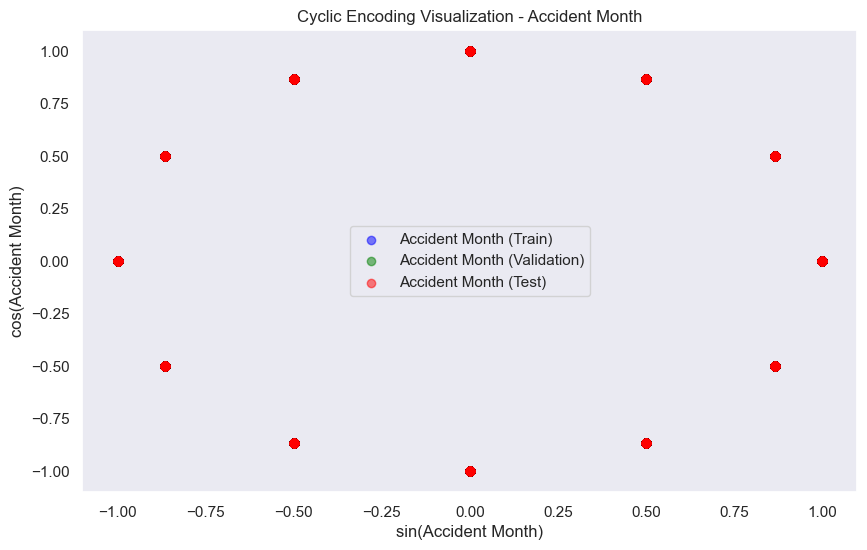

In [127]:
# Compare Train, Validation, and Test Sets with scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(X_train_cyclic_encoded['Accident Month_sin'], 
            X_train_cyclic_encoded['Accident Month_cos'], 
            label='Accident Month (Train)', alpha=0.5, color='blue')
plt.scatter(X_val_cyclic_encoded['Accident Month_sin'], 
            X_val_cyclic_encoded['Accident Month_cos'], 
            label='Accident Month (Validation)', alpha=0.5, color='green')
plt.scatter(X_test_cyclic_encoded['Accident Month_sin'], 
            X_test_cyclic_encoded['Accident Month_cos'], 
            label='Accident Month (Test)', alpha=0.5, color='red')
plt.title('Cyclic Encoding Visualization - Accident Month')
plt.xlabel('sin(Accident Month)')
plt.ylabel('cos(Accident Month)')
plt.legend()
plt.grid()
plt.show()

In [128]:
# test points (red) follow the same circular pattern as the train points (blue).
# December (near -1, 0 on the circle) is close to January (near 1, 0).

## 3.4 Data Scalling for Binary

## 3.4 Data Scaling for Target

In [129]:
# Initialize the encoder
le = LabelEncoder()

# Fit and transform the target variable in the training set

y_train_encoded = le.fit_transform(y_train_DS)
y_val_encoded = le.transform(y_val_DS)

y_train_encoded_df = pd.DataFrame(y_train_encoded, columns=['Encoded Target'], index=y_train_DS.index)
y_val_encoded_df = pd.DataFrame(y_val_encoded, columns=['Encoded Target'], index=y_val_DS.index)

In [130]:
# Combine features for the training set
X_train = pd.concat([
    pd.DataFrame(X_train_numeric_robust_scaled, index=X_train_DS.index),  # Scaled numeric features
    ohc_train_df,  # One-hot encoded categorical features
    X_train_binary,  # Binary features
    X_train_cyclic_encoded  # Cyclic encoded features
], axis=1)

# Combine features for the validation set
X_val = pd.concat([
    pd.DataFrame(X_val_numeric_robust_scaled, index=X_val_DS.index),  # Scaled numeric features
    ohc_val_df,  # One-hot encoded categorical features
    X_val_binary,  # Binary features
    X_val_cyclic_encoded  # Cyclic encoded features
], axis=1)

# Combine features for the test set
X_test = pd.concat([
    pd.DataFrame(X_test_numeric_robust_scaled, index=X_test_DS.index),  # Scaled numeric features
    ohc_test_df,  # One-hot encoded categorical features
    X_test_binary,  # Binary features
    X_test_cyclic_encoded  # Cyclic encoded features
], axis=1)


In [131]:
X_train.shape, y_train_encoded_df.shape, X_val.shape, y_val_encoded_df.shape

((418486, 316), (418486, 1), (101383, 316), (101383, 1))

In [ ]:
# Save processed training data and target variable
X_train.to_csv('datasets/scaled_data_train_delivery1.csv', index=True)
y_train_encoded_df.to_csv('datasets/scaled_target_train_delivery1.csv', index=True)

# Save processed test data
X_test.to_csv('datasets/scaled_data_test_delivery1.csv', index=True)

# Optionally, save validation data if available
X_val.to_csv('datasets/scaled_data_val_delivery1.csv', index=True)
y_val_encoded_df.to_csv('datasets/scaled_target_val_delivery1.csv', index=True)

print("Data and target variables have been saved successfully.")

Data and target variables have been saved successfully.
